**Generalized assignment problem: cutting planes generation and branch-and-cut**


A research institute has to execute a set of $I$ processes on a set of $J$ servers
of a distributed cluster run by an external service provider. 
The provider charges a cost $c_{ij}$ to execute the process $i \in I$ on the server $j \in J$. 
Once started, processes cannot moved to a different server. We assume
that all the processes have to run in parallel. For that reason, given the memory requirement
$w_{ij}$ in GB of a process $i \in I$ on the server $j \in J$, the total
memory consumption must not exceed the memory capacity $b_j$ of machine $j\in J$.
The goal is to minimize the total cost of running the given processes on the servers.

The addressed problem is known in the literature as the $\textit{generalized assignment problem}$ and it is formulated as follows 

\begin{eqnarray}
\min         & \sum_{i \in I, j \in J} c_{ij} x_{ij} \\
{\mbox s.t.} & \sum_{j \in J} x_{ij} = 1        \quad & i \in I\\
& \sum_{i \in I} w_{ij} x_{ij} \leq b_j \quad & j \in J\label{1}\\
             & x_{ij} \in \{0,1\}                \quad & i \in I, j \in J.
\end{eqnarray}

**1.   Solve the model with MIP in Python.**

In [1]:
# When using Colab, make sure you run this instruction beforehand
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 81.7 MB/s eta 0:00:00


In [2]:
import mip
import pandas as pd # to handle the data of the problem
from mip import BINARY
import numpy as np
import time

In [ ]:
# SET AND PARAMETER DEFINITION

m = 10

I = range(m)

n = 5

J = range(n)

c = pd.read_csv('c.csv',sep=';').values

w = pd.read_csv('w.csv',sep=';').values

b = pd.read_csv('b.csv',sep=';').values.flatten()

In [ ]:
model = mip.Model()

x = [[model.add_var(var_type=BINARY,name ='x_'+str(i)+str(j)) for j in J] for i in I] 

model.objective = mip.minimize(mip.xsum(x[i][j]*c[i,j] for j in J for i in I))

# CONSTRAINT
# Assignment
for i in I:
  model.add_constr(mip.xsum(x[i][j] for j in J) == 1)

# Knapsack
for j in J:
  model.add_constr(mip.xsum(w[i,j]*x[i][j] for i in I)<= b[j])

In [ ]:
# optimizing
model.optimize(relax=True)

<OptimizationStatus.OPTIMAL: 0>

In [ ]:
model.objective.x

410.02602354072945

In [ ]:
sol = np.zeros((m,n))

for i in I:
  for j in J:
    sol[i,j] = x[i][j].x

sol

array([[0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.34090909, 0.65909091, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.76470588, 0.        , 0.23529412, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.59183673, 0.        , 0.        , 0.        , 0.40816327],
       [0.36328976, 0.        , 0.        , 0.63671024, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

**2.   Propose a set of valid inequalities to strengthen this initial formulation.**

The problem can be seen as a generalization of the binary knapsack problem, where we have $|J|$ knapsacks with capacity $b_j$. Considering independently each inequality, we can use valid inequalities for the knapsack problem, i.e., the $\textit{cover inequalities}$. 
Given the inequalities for $j\in J$, $$\sum_{i \in I} w_{ij} x_{ij} \leq b_j,$$ we define a cover $C$ as the subset $C\subseteq I$ such that: $$\sum_{i \in C} w_{ij} > b_j.$$ 
Intuitively, a cover $C$ contains the indices of the items $i$ such that, if simultaneously assigned to $j$, exceed the capacity $b_j$. It is clear then that, in any feasible solution, the binary varaiables corresponding to indices in a cover $C$ cannot all have value 1. In other words, given a cover $C$, the corresponding cover inequality is valid: $$\sum_{i \in C} x_{ij} \leq |C|-1,$$ that can also be expressed as $$\sum_{i \in C} (1 - x_{ij}) \geq 1,$$ indicating that at least one variable must be 0.

The cover inequalities are valid for the generalized assignment problem, but
not for its linear relaxation: then, generating cover inequalities, we can 
improve the linear relaxation of the problem, making it stronger.

**3.   Describe the separation problem for such valid inequalities**

To generate cover inequalities, consider the optimal solution $x^*$ of the linear relaxation. Then, we solve the separation problem that allows us to find a set $C\subseteq I$ such that the cover inequality is not satisfied by $x^*$ and we add such inequality to the model. Such problem consists in maximizing the violation of a cover inequality $$\sum_{i \in C} (1 - x_{ij}) \geq 1,$$ using binary variables $z_{ij}$ that indicate which indices $i$ belong to the cover $C$ for an inequality $j$. In particular, the inequality is violated if 
\begin{equation*}
1 - \sum_{i \in I}(1-x^*_{ij})z_{ij}>0.
\end{equation*} 
The set defined by the variables $z$ is actually a cover for the $j$-th inequalities only if:
\begin{equation*}
\sum_{i \in I} w_{ij} z_{ij} > b_j.
\end{equation*}
Since, in a mathematical program, the costraints must generally be formulated with inequalities of the form $\ge$ (and not $>$), we can express the condition with the constraint $\sum_{i \in I} w_{ij} z_{ij} \geq b_j+\epsilon$, where $\epsilon > 0$. We can take $\epsilon=1$ for any $j \in J$ because in **w.csv** we can verify that the values $\left\{{\left\{ w_{ij}\right\}}_{i \in I},b_j\right\}$ are integer for any $j \in J$: this, and the fact that the variables $z_{ij}$ are binary, ensures that the difference $\sum_{i \in I} w_{ij} z_{ij} - b_j$ is integer. 
\par The procedure is iterate until no more violated cover inequalities exist.

**4.   Implement a cutting plane algorithm to solve the linear relaxation of the problem with the proposed set of valid inequalities. How does the bound change?**

In [ ]:
model = mip.Model()

nc = 0

CUTS = []

C = []

J_bar = []

x = [[model.add_var(var_type=BINARY,name ='x_'+str(i)+str(j)) for j in J] for i in I] 

model.objective = mip.minimize(mip.xsum(x[i][j]*c[i,j] for j in J for i in I))

# CONSTRAINT
# Assignment
for i in I:
  model.add_constr(mip.xsum(x[i][j] for j in J) == 1)

# Knapsack
for j in J:
  model.add_constr(mip.xsum(w[i,j]*x[i][j] for i in I)<= b[j])



newConstraints = True

while newConstraints:
    model.optimize(relax=True)

    for j in J:

      j_bar = j
      x_star = [x[i][j].x if x[i][j].x <= 1 else 1.0 for i in I]
      
      newConstraints = False
      separation = mip.Model()
      z = [separation.add_var(var_type=BINARY) for i in I]
      separation.objective = mip.maximize(1 - mip.xsum(z[i]*(1 - x_star[i]) for i in I))
      separation.add_constr(mip.xsum(w[i,j_bar]*z[i] for i in I)>= b[j_bar] + 1) 
      separation.optimize()


      violation = separation.objective.x

      if violation > 0.1:
        CUTS.append(nc)
        nc += 1
        C.append([i for i in I if z[i].x == 1])
        J_bar.append(j_bar)
        newConstraints = True
        
        break
    for k in CUTS:
      model.add_constr(mip.xsum(x[i][J_bar[k]] for i in C[k])<= len(C[k])-1) 


In [ ]:
print('Set C:')
print(C)
print('J bar:')
print(J_bar)

Set C:
[[5, 6], [5, 7], [4, 8], [0, 8], [1, 2], [2, 5, 9], [1, 6], [4, 7], [0, 4], [2, 7], [6, 9], [1, 7], [2, 3, 6]]
J bar:
[0, 0, 1, 1, 2, 0, 2, 3, 1, 2, 4, 3, 4]


In [ ]:
sol = np.zeros((m,n))

for i in I:
  for j in J:
    sol[i,j] = x[i][j].x

sol

array([[0.        , 0.40626763, 0.59373237, 0.        , 0.        ],
       [0.        , 0.        , 0.59373237, 0.40626763, 0.        ],
       [0.22203708, 0.        , 0.40626763, 0.        , 0.37169529],
       [0.        , 0.13956335, 0.        , 0.        , 0.86043665],
       [0.        , 0.59373237, 0.        , 0.40626763, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.07247057, 0.15966137, 0.76786806],
       [0.        , 0.        , 0.40626763, 0.59373237, 0.        ],
       [0.        , 0.40626763, 0.        , 0.        , 0.59373237],
       [0.76786806, 0.        , 0.        , 0.        , 0.23213194]])

In [ ]:
model.objective.x

435.58167122148905

From the solution previously obtained in **1.** we can observe that the linear relaxation
provided a lower bound of 410.02, while the formulation with the addition of valid cover
inequalities gives a lower bound of value 435.58, which is closer to the optimal value of
the original ILP problem. This confirms that these cuts restrict the feasible region of the
linear relaxation.

 **5. Solve the problem with the algorithm in MIP, observing the difference
of the branch-and-bound nodes in the case where the cutting planes generation is enabled (default settings) or completely disabled.**

The generation of cutting planes can be typically used within a branch-and-bound method, obtaining a method usually called branch-and-cut. Enabling the MIP algorithm option that allows
for the generation of cover inequalities we can notice the difference.

Solution obtained enabling only the separation of cover inequalities:

In [11]:
# optimizing
%%python

import mip

import pandas as pd

# SET AND PARAMETER DEFINITION

m = 10

I = range(m)

n = 5

J = range(n)

c = pd.read_csv('c.csv',sep=';').values

w = pd.read_csv('w.csv',sep=';').values

b = pd.read_csv('b.csv',sep=';').values.flatten()

model = mip.Model()

x = [[model.add_var(var_type=mip.BINARY,name ='x_'+str(i)+str(j)) for j in J] for i in I] 

model.objective = mip.minimize(mip.xsum(x[i][j]*c[i,j] for j in J for i in I))

# CONSTRAINT
# Assignment
for i in I:
  model.add_constr(mip.xsum(x[i][j] for j in J) == 1)

# Knapsack
for j in J:
  model.add_constr(mip.xsum(w[i,j]*x[i][j] for i in I)<= b[j])
#model.cuts = 0
#model.clique = 0
model.verbose = 1
model.preprocess = 0
model.optimize()
#progress = model.search_progress_log

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 15 (0) rows, 50 (0) columns and 100 (0) elements
Clp1000I sum of infeasibilities 3.64086e-05 - average 2.42724e-06, 25 fixed columns
Coin0506I Presolve 11 (-4) rows, 22 (-28) columns and 44 (-56) elements
Clp0029I End of values pass after 22 iterations
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Coin0511I After Postsolve, objective 410.02602, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Clp0032I Optimal objective 410.0260235 - 0 iterations time 0.002, Idiot 0.00

Starting MIP optimization
Coin3009W Conflict graph built in 0.000 seconds, density: 6.554%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Nauty did

Solution obtained disabling the cover inequalities:

In [10]:
# optimizing
%%python

import mip

import pandas as pd

# SET AND PARAMETER DEFINITION

m = 10

I = range(m)

n = 5

J = range(n)

c = pd.read_csv('c.csv',sep=';').values

w = pd.read_csv('w.csv',sep=';').values

b = pd.read_csv('b.csv',sep=';').values.flatten()

model = mip.Model()

x = [[model.add_var(var_type=mip.BINARY,name ='x_'+str(i)+str(j)) for j in J] for i in I] 

model.objective = mip.minimize(mip.xsum(x[i][j]*c[i,j] for j in J for i in I))

# CONSTRAINT
# Assignment
for i in I:
  model.add_constr(mip.xsum(x[i][j] for j in J) == 1)

# Knapsack
for j in J:
  model.add_constr(mip.xsum(w[i,j]*x[i][j] for i in I)<= b[j])
model.cuts = 0
model.clique = 0
model.verbose = 1
model.preprocess = 0
model.optimize()
#progress = model.search_progress_log

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 15 (0) rows, 50 (0) columns and 100 (0) elements
Clp1000I sum of infeasibilities 3.64086e-05 - average 2.42724e-06, 25 fixed columns
Coin0506I Presolve 11 (-4) rows, 22 (-28) columns and 44 (-56) elements
Clp0029I End of values pass after 22 iterations
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Coin0511I After Postsolve, objective 410.02602, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Clp0000I Optimal - objective value 410.02602
Clp0032I Optimal objective 410.0260235 - 0 iterations time 0.002, Idiot 0.00

Starting MIP optimization
Cbc0045I Nauty did not find any useful orbits in time 0
Cbc0038I Initial state - 8 integers unsatisfied sum - 2.69531
Cbc0038I Pass   1: suminf.    1.

Activating the generation of cover inequalities the number of nodes of the branch-and-bound tree is significantly reduced. This confirms that additing the valid inequalities makes stronger the formulations of the branch-and-bound subproblems, providing better
lower bounds, thus making the branch-and-bound more efficient.

In [ ]:
dir(progress)

In [ ]:
model.cuts_generator = SubTourCutGenerator(F, x, V)
model.lazy_constrs_generator = SubTourCutGenerator(F, x, V)
model.optimize()

In [ ]:
model = mip.Model()

nc = 0

CUTS = []

C = []

J_bar = []





newConstraints = True

while newConstraints:

    x = [[model.add_var(var_type=BINARY,name ='x_'+str(i)+str(j)) for j in J] for i in I] 

    model.objective = mip.minimize(mip.xsum(x[i][j]*c[i,j] for j in J for i in I))

    # CONSTRAINT
    # Assignment
    for i in I:
      model.add_constr(mip.xsum(x[i][j] for j in J) == 1)

    # Knapsack
    for j in J:
      model.add_constr(mip.xsum(w[i,j]*x[i][j] for i in I)<= b[j])
    for k in CUTS:
      model.add_constr(mip.xsum(x[i][J_bar[k]] for i in C[k])<= len(C[k])-1) 
    model.optimize(relax=True)

    for j in J:

      j_bar = j
      x_star = [x[i][j].x if x[i][j].x <= 1 else 1 for i in I]
      
      newConstraints = False
      print(x_star)
      separation = mip.Model()
      z = [separation.add_var(var_type=BINARY) for i in I]
      separation.objective = mip.minimize(mip.xsum(z[i]*(1 - x_star[i]) for i in I))
      separation.add_constr(mip.xsum(w[i,j_bar]*z[i] for i in I)>= b[j_bar] + 1) 
      separation.optimize()


      violation = separation.objective.x

      if violation > 0.1:
        CUTS.append(nc)
        nc += 1
        C.append([i for i in I if z[i].x == 1])
        print('Set C:')
        print(C[-1])
        print('J bar:')
        print(j_bar)
        J_bar.append(j_bar)
        newConstraints = True
        
        break
    


[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5918367346938774, 0.3632897603485837, 0.0, 0.0]
Set C:
[5, 6]
J bar:
0
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.3632897603485839, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5272727272727273]
Set C:
[5, 7]
J bar:
0
[0.0, 0.0, 0.17915659414450713, 0.0, 0.0, 1.0, 0.0, 0.0, 

KeyboardInterrupt: ignored

In [ ]:
sol = np.zeros((m,n))

for i in I:
  for j in J:
    sol[i,j] = x[i][j].x

sol

In [ ]:
c = [1]
print(c[-1])

1


In [ ]:
x = {edge: model.add_var(lb=0,name ='x_'+edge[0]+edge[1]) for edge in A}
y = {edge: model.add_var(var_type=BINARY,name = 'y_'+edge[0]+edge[1]) for edge in A}

**Problem 1: extended formulation for fixed charge network flow problem**

Consider the network topology given by the graph $G = (V,A)$ in the figure, where $V =
\{s, t, u,w\}$. Each node represents a router of the network, and each arc $(i, j \in A$ with $i, j \in V$ represents a link. The numbers associated to each arc $(i, j)$ correspond to $u_{ij} = f_{ij}$ , where $u_{ij} > 0$ is the bandwidth (arc capacity) in Mbps and $f_{ij} > 0$ is the fixed cost of using the arc.



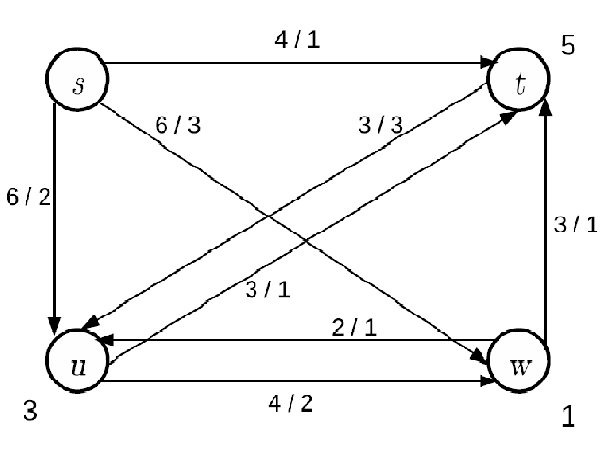

There is a single source node s and a subset $K \subseteq V \setminus \{s\}$ of destinations (terminals). Next
to each destination node $i \in K$ we report its flow (bandwidth) demand $b_i$. For the destination
nodes $i \in K$ we assume $b_i > 0$. For the source node $s, b_s$ represents the total availability, that
we assume equivalent to the sum of the demands of all nodes $i \in K$, that is, $b_s = \sum_{i \in K}b_i$.
The aim is to determine the feasible minimum cost flow that satisfies the requirements of all destinations $i \in K$.
1) Write in Python the natural MILP formulation for fixed charge network 
ow problem described in class.
2) Solve its linear relaxation. Is the optimal solution integer?


**Sets**


*   $V$: nodes
*   $A \subseteq V \times V$: arcs
*   $T \subseteq V$: destination nodes 


**Parameters**

* $s \in V\setminus T$: source node
*    $u_{ij}$: capacity of the arc $(i,j)$, with $(i,j) \in A$
*    $c_{ij}$: cost of the arc $(i,j)$, with $(i,j) \in A$
*    $b_i$: flow requirements in node $i$, with $b_i=\left \{ \begin{matrix} >0 & i \in T\\ <0 & i = s \\ 0 & otherwise  \end{matrix} \right .$


**Decision variables**

* $x_{ij}$: flow sent over the arc $(i,j)$, with $(i,j) \in E$
* $y_{ij}$: binary variable indicating if $(i,j) \in E$ is used


**Model**

For each node $i \in V$, let $\delta^{+}\left (i \right ) = \left \{ j \in V:\left ( i,j\right ) \in A\right\}$, $\delta^{-}\left (i \right ) = \left \{ j \in V:\left ( j,i\right ) \in A\right\}$. 


\begin{eqnarray*}
\min \quad & \sum_{(i,j)\in E}c_{ij}y_{ij} && \mbox{(value)}\\
\mbox{s.t.} \quad &&& \\
& \sum_{j \in \delta^{-}(i)} x_{ji} - \sum_{j \in \delta^{+}(i)} x_{ij} = b_i %\left \{ \begin{matrix}  & i = s\\ -\phi & i\in T \\ 0 & h \in V \backslash \{s,t\}  \end{matrix} \right . 
\quad & i \in V & \mbox{(balance)}\\
& x_{ij} \leq u_{ij}y_{ij} \quad & (i,j) \in A \quad & \mbox{(capacity)}\\
& x_{ij} \geq 0 & (i,j) \in A \quad & \mbox{(nonnegative var.)}\\
& y_{ij} \in \{0,1\} & (i,j) \in A \quad & \mbox{(binary var.)} 
\end{eqnarray*}

In [ ]:
import mip
#import string
import ast
import pandas as pd # to handle the data of the problem
from itertools import chain, combinations # for the computation of the powerset
from mip import BINARY
import numpy as np
import time

In [ ]:
# SET & PARAMETER DEFINITION
source = 's'
b = pd.read_csv('b_4nodes.csv',sep=';')
b.set_index('index', inplace = True)
b = b.to_dict()['b']

b[source] = - sum(list(b.values()))
V = list(b.keys())

fu = pd.read_csv('f_u4nodes.csv',sep=';')
fu['index'] = fu['index'].apply(ast.literal_eval)
fu.set_index('index', inplace = True)

f = fu.to_dict()['f']
u = fu.to_dict()['u']



# Auxiliary set A
A = list(f.keys())

In [ ]:
model = mip.Model()

In [ ]:
x = {edge: model.add_var(lb=0,name ='x_'+edge[0]+edge[1]) for edge in A}
y = {edge: model.add_var(var_type=BINARY,name = 'y_'+edge[0]+edge[1]) for edge in A}

In [ ]:
model.objective = mip.minimize(mip.xsum(f[edge]*y[edge] for edge in A))

In [ ]:
# CONSTRAINT
# Balance
for i in V:
  model.add_constr(mip.xsum(x[(j,i)] for j in V if (j,i) in A)- mip.xsum(x[(i,j)] for j in V if (i,j) in A) == b[i])

# Capacity
for edge in A:
  model.add_constr(x[edge]<= u[edge]*y[edge])

In [ ]:
# optimizing
model.optimize(relax=True)

<OptimizationStatus.OPTIMAL: 0>

In [ ]:
model.objective.x

3.1666666666666665

In [ ]:
# SET & PARAMETER DEFINITION
source = 's'
b = pd.read_csv('b_4nodes.csv',sep=';')
b.set_index('index', inplace = True)
b = b.to_dict()['b']

K = list(b.keys())
b[source] = - sum(list(b.values()))
V = list(b.keys())

d = {}
for v in V:
  for k in K:
    if v != source and v == k:
      d[(v,k)] = b[v]
    elif v == source:
      d[(v,k)] = - b[k]
    else: 
      d[(v,k)] = 0

fu = pd.read_csv('f_u4nodes.csv',sep=';')
fu['index'] = fu['index'].apply(ast.literal_eval)
fu.set_index('index', inplace = True)

f = fu.to_dict()['f']
u = fu.to_dict()['u']



# Auxiliary set A
A = list(f.keys())

In [ ]:
model1 = mip.Model()

In [ ]:
x = {(edge,k): model1.add_var(lb=0,name ='x_'+edge[0]+edge[1]+'_'+k) for edge in A for k in K}
y = {edge: model1.add_var(var_type=BINARY,name = 'y_'+edge[0]+edge[1]) for edge in A}